In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer
import os
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

os.environ["TOKENIZERS_PARALLELISM"] = "false"
def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", max_length=40, truncation=True)

In [73]:
from src.data.data_module import TextDataModule
from src.features.preprocess import preprocess

dm = TextDataModule(preprocess_fn=preprocess, vectorizer_fn=tokenize_function, tokenize_fn=None, 
                    batch_size=8, 
                    num_workers=8)
# dm.subsets["train"][0]

In [74]:
import torch
import torchmetrics
import pytorch_lightning as pl

from transformers import get_scheduler
from transformers import AutoModelForSequenceClassification

class BERTClassifier(pl.LightningModule):
    def __init__(self, num_training_steps):
        super().__init__()
        
        self.num_training_steps = num_training_steps
        self.batch_keys_keep = ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
        self.bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
        
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self, x):
        return self.bert(**x)
        
    def training_step(self, batch, batch_idx):
        batch = self.filter_batch(batch)
        outputs = self(batch)
        loss = outputs.loss
        y_hat = outputs.logits
        y = batch["labels"]
        acc = self.accuracy(y_hat, y)
        self.log("train/loss", loss)
        self.log("train/acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = self.filter_batch(batch)
        outputs = self(batch)
        val_loss = outputs.loss
        y_hat = outputs.logits
        acc = self.accuracy(y_hat, batch["labels"])
        self.log("val/loss", val_loss)
        self.log("val/acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        lr_scheduler = get_scheduler(
            name="linear", optimizer=optimizer, num_warmup_steps=0, 
            num_training_steps=self.num_training_steps
        )

        return [optimizer], [lr_scheduler]
                
    def filter_batch(self, batch):
        return {k: batch[k] for k in batch.keys() if k in self.batch_keys_keep}
    
num_epochs = 3
num_training_steps = num_epochs * len(dm.train_dataloader())

model = BERTClassifier(num_training_steps)
logger = pl.loggers.TensorBoardLogger("lightning_logs", name="bert")
trainer = pl.Trainer(accelerator="gpu",
                     logger=logger,
                     max_epochs=num_epochs)
trainer.fit(model=model, datamodule=dm)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

OSError: [Errno 122] Disk quota exceeded

In [8]:
model.device

device(type='cpu')

In [107]:
from tqdm.auto import tqdm
import torch.nn.functional as F
preds = []
actuals = []
probas = []
model.eval()
model.cuda()
for batch in tqdm(dm.val_dataloader()):
    with torch.no_grad():
        batch = model.filter_batch(batch)
        batch = {k: v.cuda() for k,v in batch.items()}
        outputs = model(batch)
        preds.append(torch.argmax(outputs.logits, dim=1))
        actuals.append(batch["labels"])
        probas.append(F.softmax(outputs.logits, dim=1))

preds = torch.cat(preds)
actuals = torch.cat(actuals)
probas = torch.cat(probas)

  0%|          | 0/619 [00:01<?, ?it/s]

0.7723412858875859


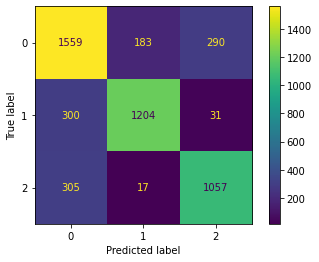

In [157]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["neutral", "positive", "negative"]
cm = confusion_matrix(actuals.cpu().numpy(), preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(accuracy_score(actuals.cpu(), preds.cpu()))

In [142]:
from textacy import preprocessing
import contractions
from src.features.preprocess import preprocess
text = "tnx"
text = contractions.fix(text, slang=True)
# preprocessing.replace.urls(text, "")
# preprocess(text)
text

'tnx'

0.7561665992721391


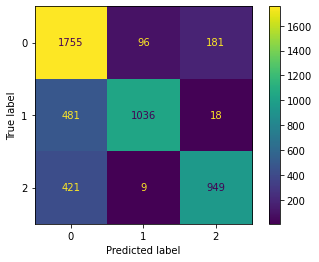

In [161]:
from sklearn.metrics import accuracy_score
thres_pos = 0.7
thres_neg = 0.6
preds_new = []
for row in probas:
    # print(row)
    if row[1] > thres_pos:
        preds_new.append(1)
    elif row[2] > thres_neg:
        preds_new.append(2)
    else:
        preds_new.append(0)
cm = confusion_matrix(actuals.cpu().numpy(), preds_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(accuracy_score(actuals.cpu(), preds_new))

In [136]:
idx = 0
probas[idx], dm.subsets["val"][idx]

(tensor([0.5617, 0.3879, 0.0504], device='cuda:0'),
 {'text': ' I always told my kids that I see and hear everything so mind your manors, so I guess that proved it to him.',
  'labels': 0,
  'preproc_text': 'i always told my kids that i see and hear everything so mind your manors so i guess that proved it to him',
  'input_ids': tensor([ 101, 1045, 2467, 2409, 2026, 4268, 2008, 1045, 2156, 1998, 2963, 2673,
          2061, 2568, 2115, 6952, 2015, 2061, 1045, 3984, 2008, 4928, 2009, 2000,
          2032,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0]),
  'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])})

In [164]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 19.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [191]:
true_pos_idxs = np.where((preds.cpu().numpy() == 1) & (actuals.cpu().numpy() == 2))

In [189]:
h = probas[true_pos_idxs, 1].cpu().numpy().squeeze()

<AxesSubplot:ylabel='Count'>

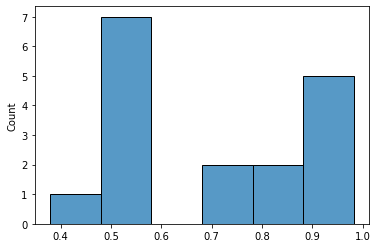

In [190]:
import numpy as np
import seaborn as sns
sns.histplot(h)

In [54]:
tokenizer.decode([  101, 28101,  2102,  2018,  2000,  2079,  2009,  2016,  2234,  2035,
          1996,  2126,  2091,  2000,  2360,  2089,  1996,  2959,  2022,  2007,
          2017,  2256,  2147,  2003,  2589])

'[CLS] britt had to do it she came all the way down to say may the fourth be with you our work is done'

In [40]:
from tqdm.auto import tqdm
preds = []
for batch in tqdm(dm.test_dataloader()):
    with torch.no_grad():
        batch = model.filter_batch(batch)
        outputs = model(batch)
        preds.append(torch.argmax(outputs.logits, dim=1))

  0%|          | 0/344 [00:01<?, ?it/s]

In [41]:
preds = torch.cat(preds)

In [ ]:
import pandas as pd
df_test = pd.read_csv("../data/raw/test.csv")
df_test

In [42]:
from src.utils import create_submission
create_submission(df_test, preds)

In [43]:
!kaggle competitions submit -c eurecom-aml-2022-challenge-3 -f submission.csv -m "BERT"

100%|██████████████████████████████████████| 35.7k/35.7k [00:00<00:00, 96.3kB/s]
Successfully submitted to EURECOM AML 2022:: Challenge 3

In [ ]:
!echo